In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Setup environment

In [ ]:
# Import essential modules
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import os
import imageio
from PIL import Image

# Part 1: Training a Single-step Denoising UNet


## 1.1 Implementing the UNet

### 1.1.1 Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.GELU()
      )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.conv(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.downconv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.GELU()
      )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.downconv(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.upconv = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.GELU()
      )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.upconv(x)


class Flatten(nn.Module):
    def __init__(self):
      super().__init__()
      self.pool = nn.Sequential(
          nn.AvgPool2d(kernel_size=7),
          nn.GELU()
      )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.pool(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
      super().__init__()
      self.unflatten = nn.Sequential(
          nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0),
          nn.BatchNorm2d(in_channels),
          nn.GELU()
      )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.unflatten(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv1 = Conv(in_channels, out_channels)
      self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.conv1(x)
      x = self.conv2(x)
      return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.downconv = DownConv(in_channels, out_channels)
      self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.downconv(x)
      x = self.convblock(x)
      return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.upconv = UpConv(in_channels, out_channels)
      self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.upconv(x)
      x = self.convblock(x)
      return x

### 1.1.2 Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()

        # Initial ConvBlock
        self.conv_in = ConvBlock(in_channels, num_hiddens)

        # Downsampling blocks
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)

        # Bottleneck
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        # Upsampling blocks
        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)

        # Output conv block
        self.conv_out = ConvBlock(num_hiddens * 2, num_hiddens)

        # Final projection to single channel
        self.final_conv = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Initial conv block
        x0 = self.conv_in(x)  # (N, D, 28, 28)

        # Downsampling
        x1 = self.down1(x0)  # (N, D, 14, 14)
        x2 = self.down2(x1)  # (N, 2D, 7, 7)

        # Bottleneck
        x3 = self.flatten(x2)  # (N, 2D, 1, 1)
        x4 = self.unflatten(x3)  # (N, 2D, 7, 7)

        # Upsampling
        x = torch.cat([x4, x2], dim=1)  # (N, 4D, 7, 7)
        x = self.up1(x)  # (N, D, 14, 14)

        x = torch.cat([x, x1], dim=1)  # (N, 2D, 14, 14)
        x = self.up2(x)  # (N, D, 28, 28)

        x = torch.cat([x, x0], dim=1)  # (N, 2D, 28, 28)
        x = self.conv_out(x)  # (N, D, 28, 28)

        # Final output
        x = self.final_conv(x)  # (N, 1, 28, 28)

        return x

## 1.2 Using the UNet to Train a Denoiser

### 1.2.0 Visualizing the noising process

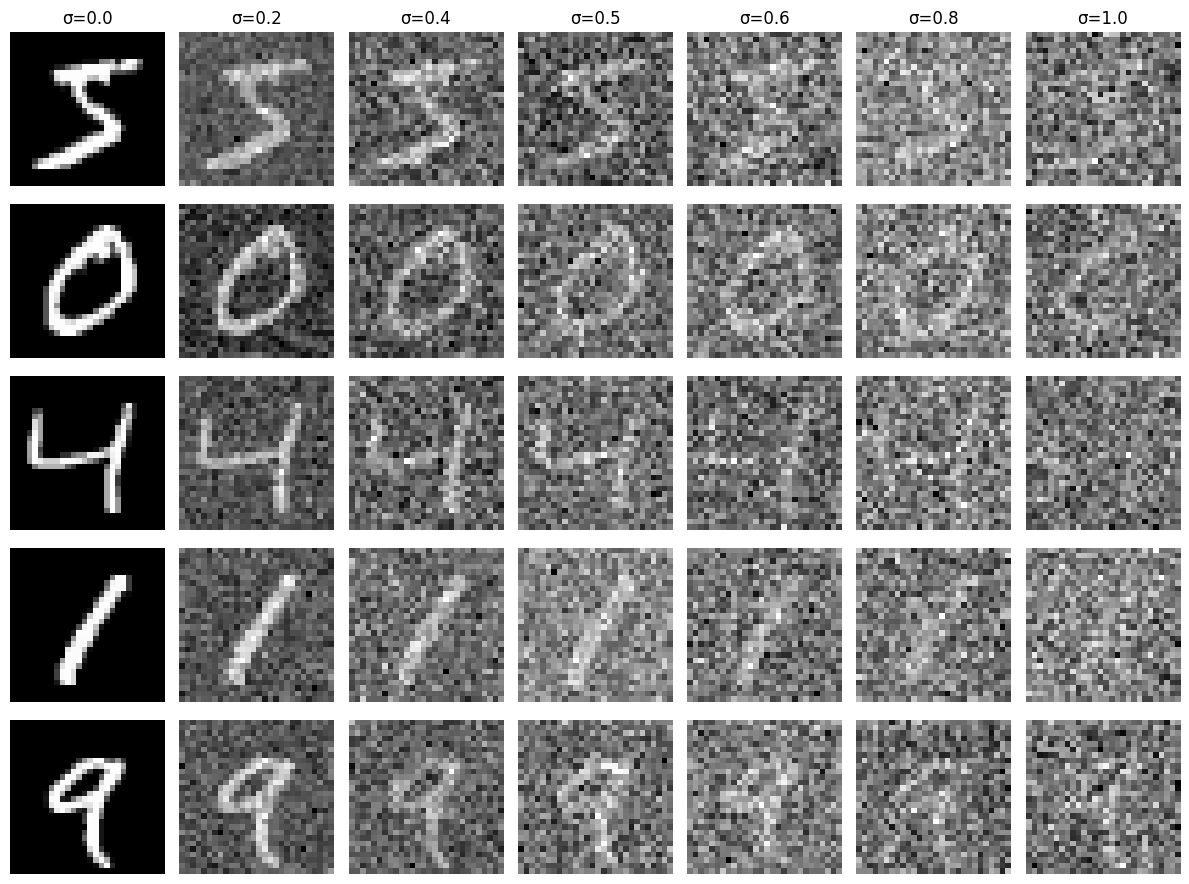

In [ ]:
dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
x, _ = dataset[0]

n_samples = 5
samples = [dataset[i][0] for i in range(n_samples)]

sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

fig, axs = plt.subplots(n_samples, len(sigmas), figsize=(12, 9))

for row_idx, x in enumerate(samples):
  for col_idx, sigma in enumerate(sigmas):
    noise = sigma * torch.randn_like(x)
    z = x + noise

    ax = axs[row_idx, col_idx]
    ax.imshow(z.squeeze(0), cmap="gray")
    ax.axis("off")

    if row_idx == 0:
        ax.set_title(f"σ={sigma}")

plt.tight_layout()
plt.show()

### 1.2.1 Training a Single-Step Unconditional UNet

- Plot the loss curve
- Sample results on the test set

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Initialize model
model = UnconditionalUNet(in_channels=1, num_hiddens=128).to('cuda')

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
n_epochs = 5
sigma = 0.5

losses = []

model.train()
for epoch in range(n_epochs):
  print(f"Starting epoch {epoch+1}/{n_epochs}...")

  for x, _ in dataloader:
    x = x.to('cuda')

    # Generate noisy input z
    noise = sigma * torch.randn_like(x)
    z = x + noise # Eq. B.2

    # Predict and compute loss
    output = model(z)
    loss = criterion(output, x) # Eq. B.1

    # Update model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  if epoch + 1 == 1:
    torch.save(model.state_dict(), "path/checkpoints/single_unet_epoch1.pth")
    print("Saved model after 1st epoch!")

  if epoch + 1 == 5:
    torch.save(model.state_dict(), "path/checkpoints/single_unet_epoch5.pth")
    print("Saved model after 5th epoch!")

Starting epoch 1/5
Saved model after 1st epoch!
Starting epoch 2/5
Starting epoch 3/5
Starting epoch 4/5
Starting epoch 5/5
Saved model after 5th epoch!


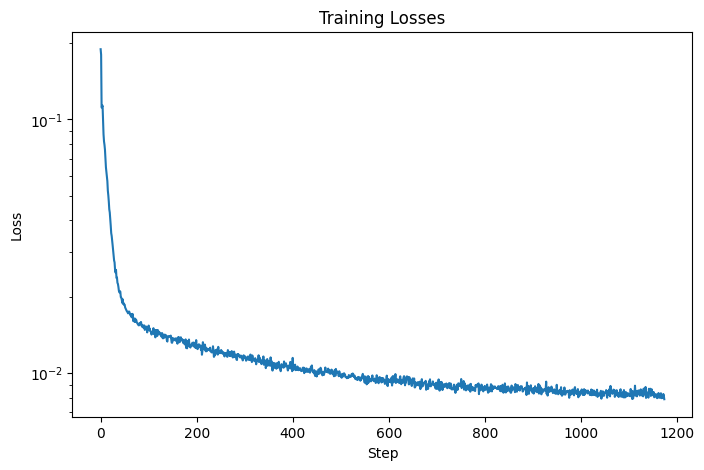

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Losses")
plt.show()

In [ ]:
def visualize_samples(model, samples, sigma=0.5, device='cuda'):

    model.eval()
    fig, axs = plt.subplots(len(samples), 3, figsize=(8, 8))

    for row_idx, x in enumerate(samples):
        x = x.to(device)

        # Create noisy version
        noise = sigma * torch.randn_like(x)
        z = x + noise

        # Denoise
        with torch.no_grad():
            x_denoised = model(z)

        # Plot
        axs[row_idx, 0].imshow(x.squeeze().cpu(), cmap="gray")
        axs[row_idx, 0].set_title("Input")
        axs[row_idx, 1].imshow(z.squeeze().cpu(), cmap="gray")
        axs[row_idx, 1].set_title(f"Noisy (σ={sigma})")
        axs[row_idx, 2].imshow(x_denoised.squeeze().cpu(), cmap="gray", vmin=0, vmax=1)
        axs[row_idx, 2].set_title("Output")

        for col_idx in range(3):
            axs[row_idx, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Load MNIST test set
test_dataset = MNIST(root="data", download=True, train=False, transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Select some samples
samples = []
for i, (x, _) in enumerate(test_loader):
    if i >= 3:
        break
    samples.append(x)

Epoch 1

In [ ]:
# Re-initialize the model architecture
model = UnconditionalUNet(in_channels=1, num_hiddens=128).to('cuda')

# Load saved weights
model.load_state_dict(torch.load('path/checkpoints/single_unet_epoch1.pth'))
model.eval()

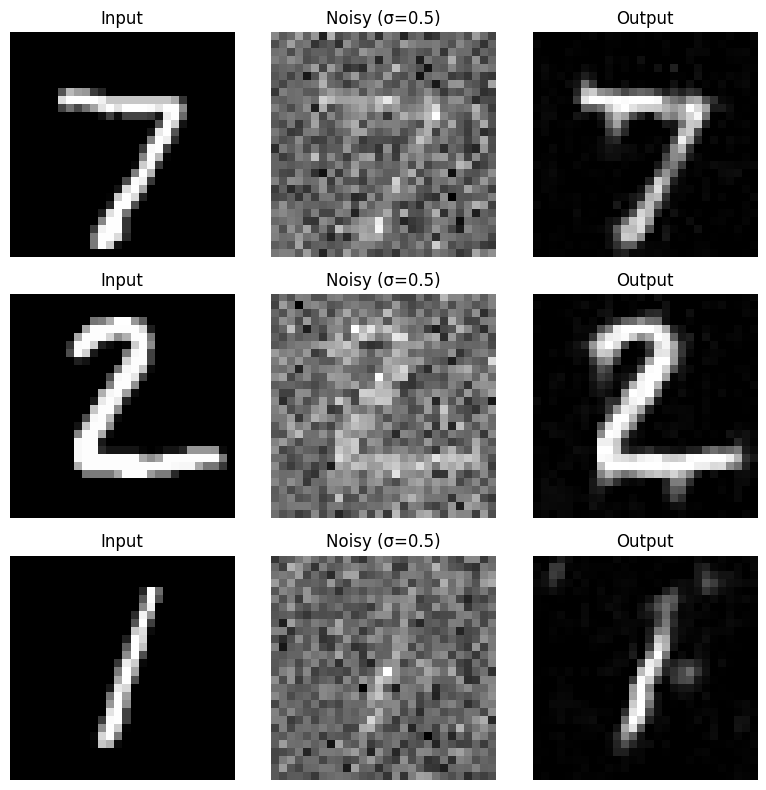

In [ ]:
visualize_samples(model, samples, sigma=0.5, device='cuda')

Epoch 5

In [ ]:
# Re-initialize the model architecture
model = UnconditionalUNet(in_channels=1, num_hiddens=128).to('cuda')

# Load saved weights
model.load_state_dict(torch.load('path/checkpoints/single_unet_epoch5.pth'))
model.eval()

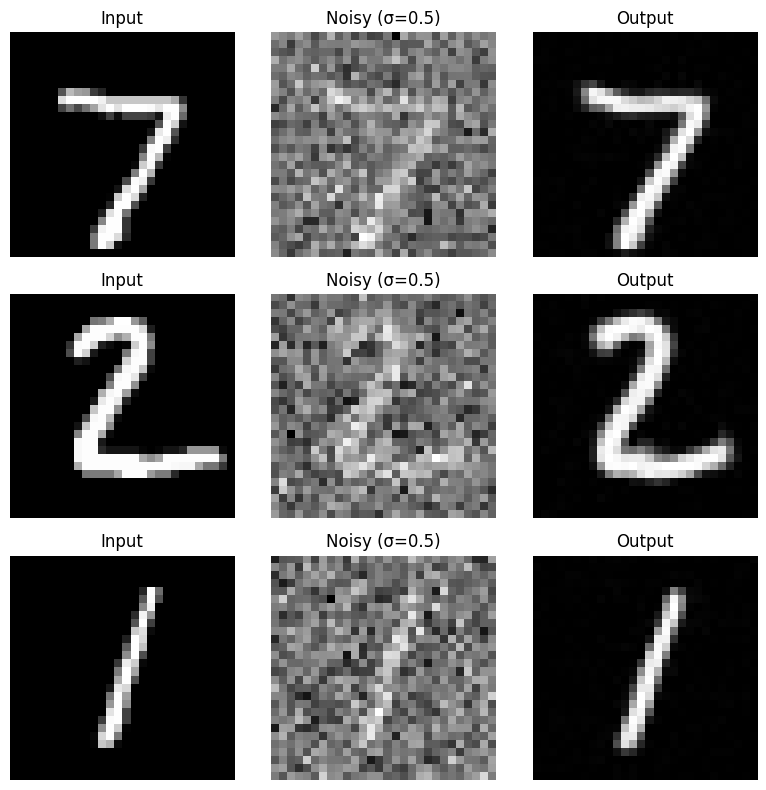

In [ ]:
visualize_samples(model, samples, sigma=0.5, device='cuda')

### 1.2.2 Out-of-Distribution Testing

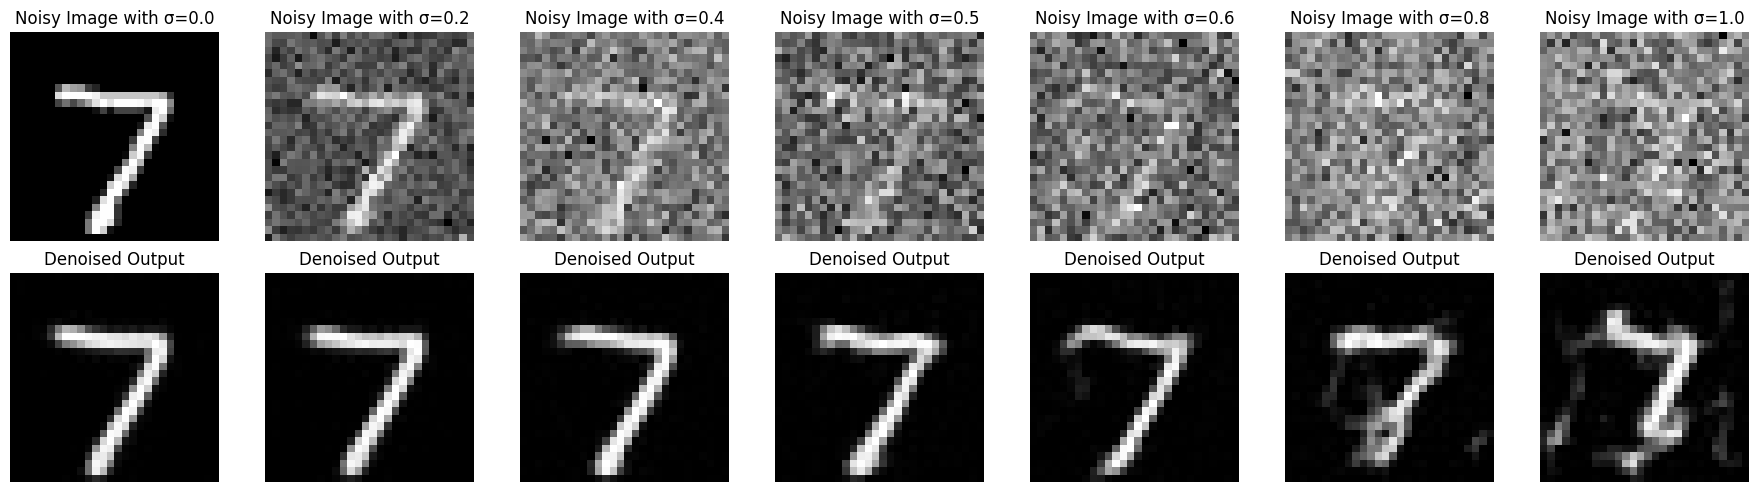

In [ ]:
x, _ = test_dataset[0]
x = x.unsqueeze(0).to('cuda')

# Define noise levels
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

noisy_images = []
denoised_images = []

# Generate noisy and denoised images
for sigma in sigmas:
    noise = sigma * torch.randn_like(x)
    z = x + noise
    noisy_images.append(z.squeeze(0).cpu())

    with torch.no_grad():
        x_denoised = model(z)
    denoised_images.append(x_denoised.squeeze(0).cpu())

# Plot
n_cols = len(sigmas)
fig, axs = plt.subplots(2, n_cols, figsize=(18, 5))

for col_idx in range(n_cols):
    # Plot noisy image
    axs[0, col_idx].imshow(noisy_images[col_idx].squeeze(0), cmap="gray")
    axs[0, col_idx].axis('off')
    axs[0, col_idx].set_title(f"Noisy Image with σ={sigmas[col_idx]}")

    # Plot denoised output
    axs[1, col_idx].imshow(denoised_images[col_idx].squeeze(0), cmap="gray", vmin=0, vmax=1)
    axs[1, col_idx].axis('off')
    axs[1, col_idx].set_title("Denoised Output")

plt.tight_layout()
plt.show()

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.block = nn.Sequential(
          nn.Linear(in_channels, out_channels),
          nn.GELU(),
          nn.Linear(out_channels, out_channels)
      )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.block(x)


class TimeConditionalUNet(UnconditionalUNet):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__(in_channels, num_hiddens)
        # FCBlocks to embed time t
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        # assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Embed time
        t1 = self.fc1_t(t.unsqueeze(-1))  # (N, 2D)
        t2 = self.fc2_t(t.unsqueeze(-1))  # (N, D)

        t1 = t1.view(t1.shape[0], -1, 1, 1)  # (N, 2D, 1, 1)
        t2 = t2.view(t2.shape[0], -1, 1, 1)  # (N, D, 1, 1)

        # Modified U-Net Architecture
        x0 = self.conv_in(x) # (N, D, 28, 28)

        # Downsampling
        x1 = self.down1(x0)  # (N, D, 14, 14)
        x2 = self.down2(x1)  # (N, 2D, 7, 7)

        # Bottleneck
        x3 = self.flatten(x2)  # (N, 2D, 1, 1)
        x4 = self.unflatten(x3)  # (N, 2D, 7, 7)
        x4 = x4 + t1  # Inject time at unflatten

        # Upsampling
        x = torch.cat([x4, x2], dim=1)  # (N, 4D, 7, 7)
        x = self.up1(x)  # (N, D, 14, 14)
        x = x + t2  # Inject time at up1

        x = torch.cat([x, x1], dim=1)  # (N, 2D, 14, 14)
        x = self.up2(x)  # (N, D, 28, 28)

        x = torch.cat([x, x0], dim=1)  # (N, 2D, 28, 28)
        x = self.conv_out(x)  # (N, D, 28, 28)

        x = self.final_conv(x)  # (N, 1, 28, 28)
        return x

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts)  # (T, )
    alphas = 1.0 - betas  # (T, )
    alpha_bars = torch.cumprod(alphas, dim=0)  # (T, )

    schedule = {"betas": betas,
                "alphas": alphas,
                "alpha_bars": alpha_bars}

    return schedule

In [ ]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    N = x_0.shape[0]

    # 1. Sample t ~ Uniform(1, ..., T)
    t = torch.randint(low=1, high=num_ts+1, size=(N, ), device=x_0.device) # (N, )

    # 2. Sample noise eps ~ N(0, I)
    eps = torch.randn_like(x_0)

    # 3. Compute x_t
    alpha_bar = ddpm_schedule["alpha_bars"][t-1].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar)*x_0 + torch.sqrt(1.0-alpha_bar)*eps

    # 4. Compute eps_hat
    t_norm = t/num_ts  # normalize t to [0, 1]
    eps_hat = unet(x_t, t_norm)

    # 5. Compute loss
    loss = F.mse_loss(eps_hat, eps)

    return loss

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    torch.manual_seed(seed)

    # 1. Precompute betas, alphas, and alpha_bars
    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alpha_bars = ddpm_schedule["alpha_bars"]

    # 2. Sample x_T ~ N(0, I)
    H, W = img_wh
    x_t = torch.randn((1, 1, H, W), device=betas.device)

    frames = [x_t.clone()] # for GIF

    # 3. Iterate from T to 1
    for t in range(num_ts, 0, -1):
      t = torch.tensor([t], device=betas.device)  # (1, )
      t_norm = t.expand(x_t.shape[0])/num_ts  # normalize t to [0, 1]

      # 4. z ~ N(0, I) if t>1, else z=0
      z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)  # (1, 1, H, W)

      # 5. Compute x_0_hat
      eps_hat = unet(x_t, t_norm) # compute eps_hat
      alpha_bar_t = alpha_bars[t-1]
      x0_hat = (x_t - torch.sqrt(1 - alpha_bar_t)*eps_hat) / torch.sqrt(alpha_bar_t)

      # 6. Compute x_{t-1}
      beta_t = betas[t-1]
      alpha_t = alphas[t-1]
      alpha_bar_prev = alpha_bars[t-2] if t > 1 else torch.tensor(1.0, device=x_t.device)

      # Compute constants
      a = torch.sqrt(alpha_bar_prev)*beta_t / (1 - alpha_bar_t)
      b = torch.sqrt(alpha_t) * (1 - alpha_bar_prev) / (1 - alpha_bar_t)

      x_t = a*x0_hat + b*x_t + torch.sqrt(beta_t)*z

      frames.append(x_t.clone())

    return frames

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

## Training the Time-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.3kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.15MB/s]


In [ ]:
n_epochs = 20
batch_size = 128
hidden_dim = 64
betas = (0.0001, 0.02)
num_ts = 300
lr = 1e-3

in_channels = 1
num_classes = 1

In [ ]:
# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tc_unet = TimeConditionalUNet(in_channels, num_classes, hidden_dim).to(device)
model = DDPM(tc_unet, betas, num_ts).to(device)

# Optimizer and scheduler
optimizer = optim.Adam(tc_unet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/n_epochs))

losses = []
model.train()

# Training loop
for epoch in range(n_epochs):
    print(f"Starting epoch {epoch+1}/{n_epochs}...")

    for x, _ in dataloader:
        x = x.to(device)

        # Compute DDPM loss
        loss = model(x)

        # Backpropagation and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Step the LR scheduler
    scheduler.step()

    # Save checkpoints
    if epoch+1 in {1, 5, 10, 15, 20}:
        torch.save(model.state_dict(), f"path/checkpoints/ddpm_epoch_{epoch+1}.pth")
        print(f"Saved model at epoch {epoch+1}!")

Starting epoch 1/20...
Saved model at epoch 1!
Starting epoch 2/20...
Starting epoch 3/20...
Starting epoch 4/20...
Starting epoch 5/20...
Saved model at epoch 5!
Starting epoch 6/20...
Starting epoch 7/20...
Starting epoch 8/20...
Starting epoch 9/20...
Starting epoch 10/20...
Saved model at epoch 10!
Starting epoch 11/20...
Starting epoch 12/20...
Starting epoch 13/20...
Starting epoch 14/20...
Starting epoch 15/20...
Saved model at epoch 15!
Starting epoch 16/20...
Starting epoch 17/20...
Starting epoch 18/20...
Starting epoch 19/20...
Starting epoch 20/20...
Saved model at epoch 20!


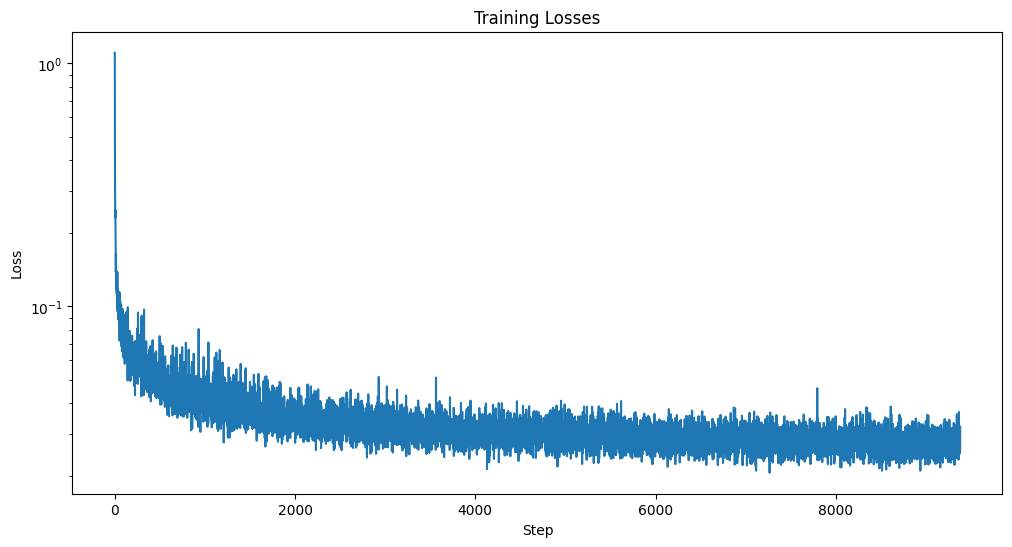

In [ ]:
# Plot training curve
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.yscale('log')
plt.title("Training Losses")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

Visualize samples for each epoch

Epoch 1


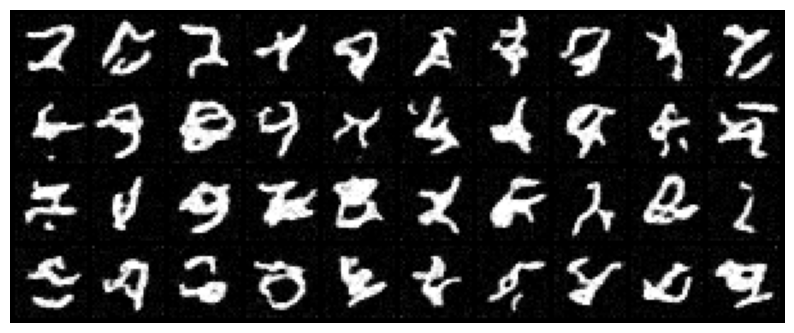



Epoch 5


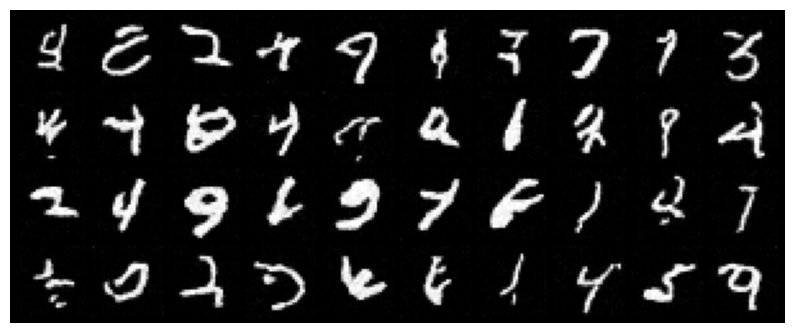



Epoch 10


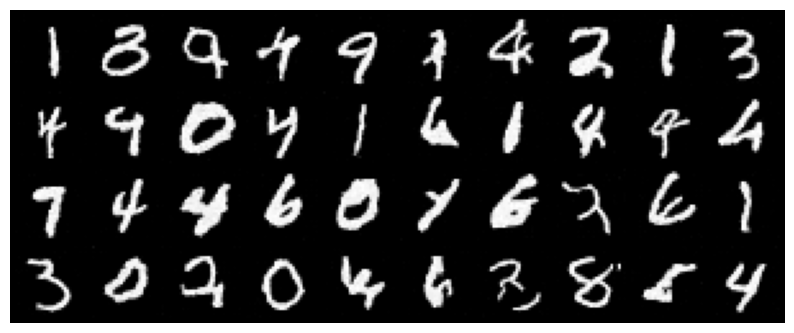



Epoch 15


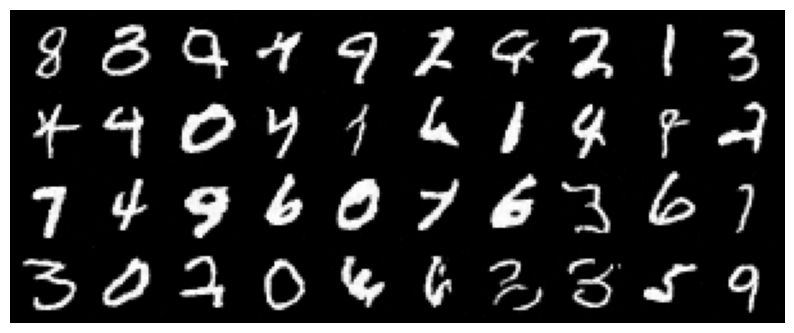



Epoch 20


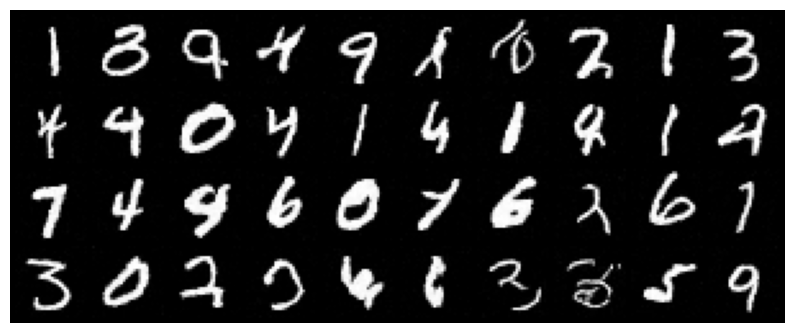

In [ ]:
path = "path/checkpoints/ddpm_epoch_{}.pth"
epochs = [1, 5, 10, 15, 20]

grid_size = (4, 10)

for epoch in epochs:

    # Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tc_unet = TimeConditionalUNet(in_channels, num_classes, hidden_dim).to(device)
    model = DDPM(tc_unet, betas, num_ts).to(device)

    model.load_state_dict(torch.load(path.format(epoch)))
    model.eval()

    # Generate samples
    samples = []
    for i in range(40):
        frames = model.sample(img_wh=(28, 28), seed=i)
        samples.append(frames[-1])  # Final denoised image

    samples_tensor = torch.stack(samples)

    # Create grid and display
    grid = make_grid(samples_tensor.clamp(0, 1), nrow=grid_size[1], padding=2)
    plt.figure(figsize=(10, 10))
    print(f"Epoch {epoch}")
    plt.imshow(to_pil_image(grid), cmap='gray')
    plt.axis("off")
    plt.show()
    print("\n")

GIF generation

In [ ]:
def create_gif(all_frames, epoch, save_path, scale=2, duration=25, cc=False):
    num_ts = len(all_frames[0])
    gif_frames = []

    for t in range(num_ts):
      step_imgs = [frames[t] for frames in all_frames]
      step_imgs = torch.cat(step_imgs, dim=0)
      step_imgs = step_imgs.clamp(0, 1).cpu()

      if cc:
        step_imgs = step_imgs.view(10, 4, 1, 28, 28).permute(1, 0, 2, 3, 4).reshape(-1, 1, 28, 28)

      grid = make_grid(step_imgs, nrow=10, padding=0)
      pil_img = to_pil_image(grid)

      new_size = (pil_img.width * scale, pil_img.height * scale)
      pil_img = pil_img.resize(new_size, resample=Image.NEAREST)

      gif_frames.append(pil_img)

    gif_filename = save_path.format(epoch)
    gif_frames[0].save(gif_filename, save_all=True, append_images=gif_frames[1:],
                       duration=duration, loop=0)


    print(f"Saved GIF for epoch {epoch}!")

In [ ]:
# Setup
path = "path/checkpoints/ddpm_epoch_{}.pth"
save_path = "path/gifs/time/denoising_epoch_{}.gif"

epochs = [1, 5, 10, 15, 20]
grid_size = (4, 10)

for epoch in epochs:
  # Load model
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  tc_unet = TimeConditionalUNet(in_channels, num_classes, hidden_dim).to(device)
  model = DDPM(tc_unet, betas, num_ts).to(device)
  model.load_state_dict(torch.load(path.format(epoch)))
  model.eval()

  # Generate samples
  all_frames = []
  for seed in range(40):
    frames = model.sample(img_wh=(28, 28), seed=seed)
    all_frames.append(frames)

  # Create and save gifs
  create_gif(all_frames, epoch, save_path)

Saved GIF for epoch 1!
Saved GIF for epoch 5!
Saved GIF for epoch 10!
Saved GIF for epoch 15!
Saved GIF for epoch 20!


## Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(UnconditionalUNet):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__(in_channels, num_hiddens)
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc1_c = FCBlock(num_classes, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        # assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # Convert c to one-hot vector
        c_onehot = torch.zeros(c.size(0), num_classes, device=c.device)  # (N, num_classes)
        c_onehot.scatter_(1, c.unsqueeze(1), 1.0)

        # Dropout: zero out class embedding for samples where mask == 0
        if mask is not None:
          c_onehot = c_onehot * mask.unsqueeze(1)

        # Embed time and class
        t1 = self.fc1_t(t.unsqueeze(-1))  # (N, 2D)
        c1 = self.fc1_c(c_onehot)  # (N, 2D)
        t2 = self.fc2_t(t.unsqueeze(-1))  # (N, D)
        c2 = self.fc2_c(c_onehot)  # (N, D)

        t1 = t1.view(t1.shape[0], -1, 1, 1)  # (N, 2D, 1, 1)
        c1 = c1.view(c1.shape[0], -1, 1, 1)  # (N, 2D, 1, 1)
        t2 = t2.view(t2.shape[0], -1, 1, 1)  # (N, D, 1, 1)
        c2 = c2.view(c2.shape[0], -1, 1, 1)  # (N, D, 1, 1)

        # Modified U-Net Architecture
        x0 = self.conv_in(x) # (N, D, 28, 28)

        # Downsampling
        x1 = self.down1(x0)  # (N, D, 14, 14)
        x2 = self.down2(x1)  # (B, 2D, 7, 7)

        # Bottleneck
        x3 = self.flatten(x2)  # (N, 2D, 1, 1)
        x4 = self.unflatten(x3)  # (N, 2D, 7, 7)
        x4 = c1 * x4 + t1  # Inject time and class conditioning at unflatten

        # Upsampling
        x = torch.cat([x4, x2], dim=1)  # (N, 4D, 7, 7)
        x = self.up1(x)  # (N, D, 14, 14)
        x = c2 * x + t2  # Inject time and class conditioning at up1

        x = torch.cat([x, x1], dim=1)  # (N, 2D, 14, 14)
        x = self.up2(x)  # (N, D, 28, 28)

        x = torch.cat([x, x0], dim=1)  # (N, 2D, 28, 28)
        x = self.conv_out(x)  # (N, D, 28, 28)

        x = self.final_conv(x)  # (N, 1, 28, 28)
        return x

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    N = x_0.shape[0]

    # 1. Sample t ~ Uniform(1, ..., T)
    t = torch.randint(low=1, high=num_ts+1, size=(N, ), device=x_0.device) # (N, )

    # 2. Sample noise eps ~ N(0, I)
    eps = torch.randn_like(x_0)

    # 3. Compute x_t
    alpha_bar = ddpm_schedule["alpha_bars"][t-1].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar)*x_0 + torch.sqrt(1.0-alpha_bar)*eps

    # 4. Create mask for unconditional generation
    mask = (torch.rand(N, device=x_0.device) > p_uncond).float()

    # 5. Compute eps_hat
    t_norm = t/num_ts  # normalize t to [0, 1]
    eps_hat = unet(x_t, c, t_norm, mask)

    # 6. Compute loss
    loss = F.mse_loss(eps_hat, eps)

    return loss

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    torch.manual_seed(seed)

    # 1. Precompute betas, alphas, and alpha_bars
    betas = ddpm_schedule["betas"]
    alphas = ddpm_schedule["alphas"]
    alpha_bars = ddpm_schedule["alpha_bars"]

    # 2. Sample x_T ~ N(0, I)
    H, W = img_wh
    N = c.shape[0]
    x_t = torch.randn((N, 1, H, W), device=betas.device)

    frames = [x_t.clone()] # for GIF

    # 3. Iterate from T to 1
    for t in range(num_ts, 0, -1):
      t = torch.tensor([t], device=betas.device)  # (1, )
      t_norm = t.expand(N)/num_ts  # normalize t to [0, 1]

      # 4. z ~ N(0, I) if t>1, else z=0
      z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)  # (N, 1, H, W)

      # 5. Compute eps_c and eps_u
      eps_c = unet(x_t, c, t_norm)
      eps_u = unet(x_t, torch.zeros_like(c), t_norm)

      # 6. Compute x_0_hat
      eps_hat = eps_u + guidance_scale*(eps_c - eps_u) # compute eps_hat
      alpha_bar_t = alpha_bars[t-1]
      x0_hat = (x_t - torch.sqrt(1 - alpha_bar_t)*eps_hat) / torch.sqrt(alpha_bar_t)

      # 7. Compute x_{t-1}
      beta_t = betas[t-1]
      alpha_t = alphas[t-1]
      alpha_bar_prev = alpha_bars[t-2] if t > 1 else torch.tensor(1.0, device=x_t.device)

      # Compute constants
      a = torch.sqrt(alpha_bar_prev)*beta_t / (1 - alpha_bar_t)
      b = torch.sqrt(alpha_t) * (1 - alpha_bar_prev) / (1 - alpha_bar_t)

      x_t = a*x0_hat + b*x_t + torch.sqrt(beta_t)*z

      frames.append(x_t.clone())

    return frames

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

## Training the Class-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
n_epochs = 20
batch_size = 128
hidden_dim = 64
betas = (0.0001, 0.02)
num_ts = 300
lr = 1e-3

in_channels = 1
num_classes = 10  # for digits 0-9

In [ ]:
# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cc_unet = ClassConditionalUNet(in_channels, num_classes, hidden_dim).to(device)
model = DDPM(cc_unet, betas, num_ts).to(device)

# Optimizer and scheduler
optimizer = optim.Adam(tc_unet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/n_epochs))

losses = []
model.train()

# Training loop
for epoch in range(n_epochs):
  print(f"Starting epoch {epoch + 1}/{n_epochs}...")

  for x, y in dataloader:
    x = x.to(device)  # (N, 1, 28, 28)
    y = y.to(device)  # (N, )

    # Compute DDPM loss
    loss = model(x,y)

    # Backpropagation and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

  # Step the LR scheduler
  scheduler.step()

  # Save checkpoints
  if epoch + 1 in {1, 5, 10, 15, 20}:
    torch.save(model.state_dict(), f"path/checkpoints/ct_ddpm_epoch_{epoch+1}.pth")
    print(f"Saved model at epoch {epoch+1}!")

Starting epoch 1/20...
Saved model at epoch 1!
Starting epoch 2/20...
Starting epoch 3/20...
Starting epoch 4/20...
Starting epoch 5/20...
Saved model at epoch 5!
Starting epoch 6/20...
Starting epoch 7/20...
Starting epoch 8/20...
Starting epoch 9/20...
Starting epoch 10/20...
Saved model at epoch 10!
Starting epoch 11/20...
Starting epoch 12/20...
Starting epoch 13/20...
Starting epoch 14/20...
Starting epoch 15/20...
Saved model at epoch 15!
Starting epoch 16/20...
Starting epoch 17/20...
Starting epoch 18/20...
Starting epoch 19/20...
Starting epoch 20/20...
Saved model at epoch 20!


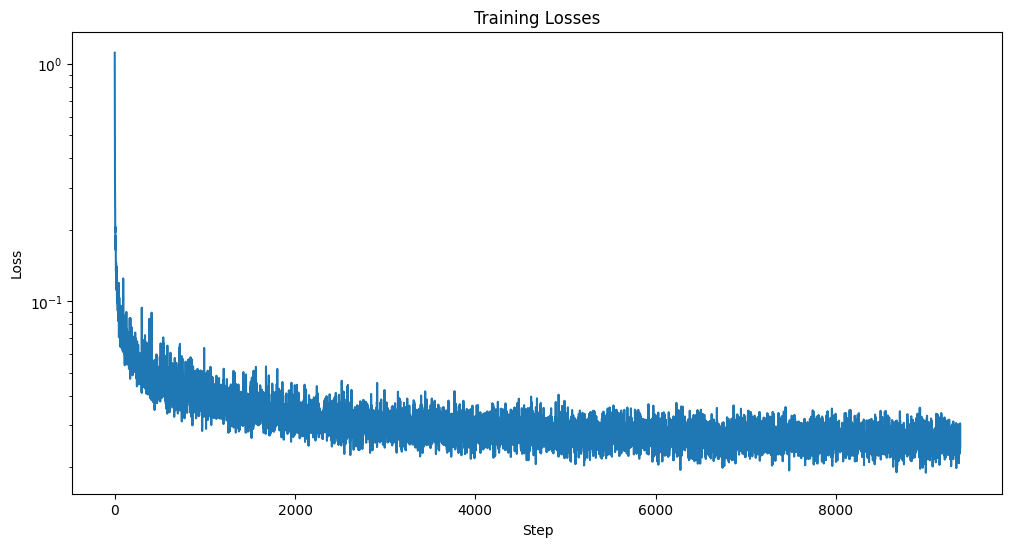

In [ ]:
# Plot training curve
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.yscale('log')
plt.title("Training Losses")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

Visualize samples for each epoch

Epoch 1


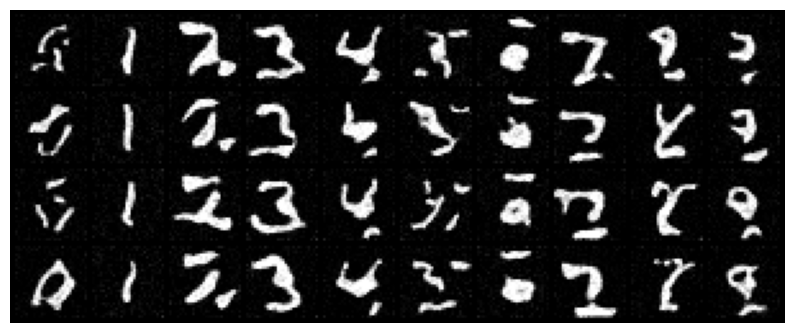



Epoch 5


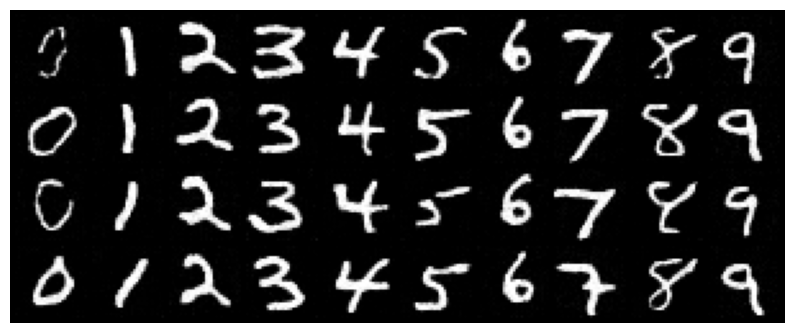



Epoch 10


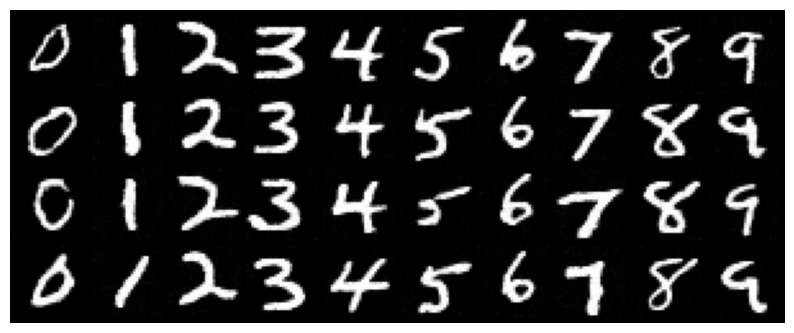



Epoch 15


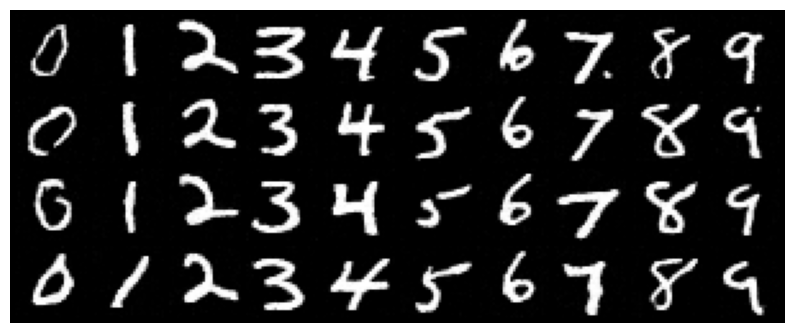



Epoch 20


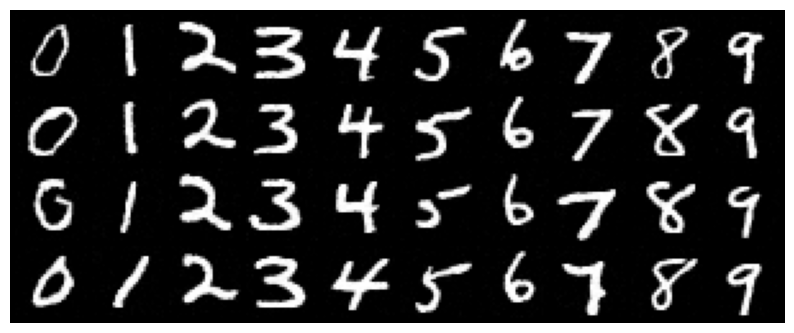

In [ ]:
# Settings
path = "path/checkpoints/ct_ddpm_epoch_{}.pth"
epochs = [1, 5, 10, 15, 20]

grid_size = (4, 10)

# Start loop
for epoch in epochs:
  # Load model
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  cc_unet = ClassConditionalUNet(in_channels, num_classes=10, num_hiddens=hidden_dim).to(device)
  model = DDPM(cc_unet, betas, num_ts).to(device)

  model.load_state_dict(torch.load(path.format(epoch)))
  model.eval()

  # Generate conditioned samples
  samples = []
  for class_id in range(10):
    c = torch.full((4,), class_id, dtype=torch.long, device=device)
    frames = model.sample(c=c, img_wh=(28, 28), seed=class_id)
    samples.append(frames[-1])  # Final denoised image

  samples_tensor = torch.stack(samples)

  # Create grid
  samples_tensor = samples_tensor.view(10, 4, 1, 28, 28).permute(1, 0, 2, 3, 4).reshape(-1, 1, 28, 28)
  grid = make_grid(samples_tensor.clamp(0, 1), nrow=10, padding=2)

  # Display
  plt.figure(figsize=(10, 10))
  print(f"Epoch {epoch}")
  plt.imshow(to_pil_image(grid), cmap='gray')
  plt.axis("off")
  plt.show()
  print("\n")

GIF generation

In [ ]:
# Setup
path = "path/checkpoints/ct_ddpm_epoch_{}.pth"
save_path = "path/gifs/class_time/denoising_epoch_{}.gif"

epochs = [1, 5, 10, 15, 20]
grid_size = (4, 10)

for epoch in epochs:
  # Load model
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  cc_unet = ClassConditionalUNet(in_channels, num_classes=10, num_hiddens=hidden_dim).to(device)
  model = DDPM(cc_unet, betas, num_ts).to(device)
  model.load_state_dict(torch.load(path.format(epoch)))
  model.eval()

  # Generate samples
  all_frames = []
  for class_id in range(10):
    c = torch.full((4,), class_id, dtype=torch.long, device=device)
    frames = model.sample(c=c, img_wh=(28, 28), seed=class_id)
    all_frames.append(frames)

  # Create and save gifs
  create_gif(all_frames, epoch, save_path, cc=True)

Saved GIF for epoch 1!
Saved GIF for epoch 5!
Saved GIF for epoch 10!
Saved GIF for epoch 15!
Saved GIF for epoch 20!
